In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

raw = pd.read_csv('stock_prices_10yr_all_companies.csv', header=None)

unrate = pd.read_csv("UNRATE.csv", parse_dates=['observation_date'])
unrate.rename(columns={'observation_date': 'Date'}, inplace=True)

tickers = raw.iloc[0, 1:].values
features = raw.iloc[1, 1:].values
columns = ['Date'] + [f'{tickers[i]}_{features[i]}' for i in range(len(tickers))]

df = pd.DataFrame(raw.values[2:], columns=columns)

# Cleanup
df = df[df['Date'].astype(str) != 'Date']
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d', errors='coerce')
df = df.dropna(subset=['Date'])  # drop rows with invalid dates

unrate['UNRATE'] = pd.to_numeric(unrate['UNRATE'], errors='coerce')
unrate['Unrate_Pct_Change'] = unrate['UNRATE'].pct_change() * 100
df = pd.merge_asof(df.sort_values('Date'), unrate.sort_values('Date'), on='Date')

print(df)


           Date          Close_CHTR         Close_CMCSA          Close_DIS  \
0    2015-04-06  193.19000244140625  23.233482360839844   97.2472152709961   
1    2015-04-07              189.75  23.277387619018555   97.0630874633789   
2    2015-04-08  190.77999877929688   23.62064552307129   97.9192886352539   
3    2015-04-09  190.92999267578125   23.78428840637207  98.29674530029297   
4    2015-04-10  191.80999755859375  23.872098922729492  98.46245574951172   
...         ...                 ...                 ...                ...   
2512 2025-03-31   368.5299987792969  36.568382263183594  98.69999694824219   
2513 2025-04-01   370.9100036621094   36.38999938964844  97.68000030517578   
2514 2025-04-02   379.2699890136719   36.61000061035156  97.87999725341797   
2515 2025-04-03   368.3999938964844  35.720001220703125  88.83999633789062   
2516 2025-04-04   338.2900085449219  33.380001068115234  83.52999877929688   

             Close_GOOGL         Close_META          Close_NFLX

In [33]:
best_accuracy = 0
best_ratio = None
targets = "GOOGL", "META", "NFLX", "TMUS", "DIS", "T", "VZ", "CMCSA", "SPOT", "CHTR"
for split_ratio in np.arange(0.5, 0.99, 0.01):
    print(f"\nTrying split ratio: {split_ratio:.0%}")
    accuracies = []
    for target in targets:
        temp_df = df.copy()
        cols = [f'Close_{target}', f'High_{target}', f'Low_{target}']
        temp_df[cols] = temp_df[cols].astype(float)
        temp_df['Prev_Close'] = temp_df[f'Close_{target}'].shift(1)
        temp_df['Target_Up'] = (temp_df[f'Close_{target}'] > temp_df['Prev_Close']).astype(int)
        temp_df.dropna(inplace=True)

        scaler = MinMaxScaler()

        X = temp_df[['Prev_Close', 'UNRATE','Unrate_Pct_Change']].values
        scaled = scaler.fit_transform(X)
        y = temp_df['Target_Up'].values

        split = int(len(X) * split_ratio)
        X_train, y_train = X[:split], y[:split]
        X_test, y_test = X[split:], y[split:]
        dates_test = temp_df['Date'].iloc[split:]
        real_close = temp_df[f'Close_{target}'].iloc[split:].values

        model = LogisticRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        real_trend = np.where(np.diff(real_close) > 0, 1, 0)
        pred_trend = y_pred[:-1]
        trend_accuracy = accuracy_score(real_trend, pred_trend)
        accuracies.append(trend_accuracy)
    
    avg_accuracy = sum(accuracies) / len(accuracies)
    print(f"Average Accuracy for split ratio {split_ratio:.0%}: {avg_accuracy:.2%}")
    
    if all(a > 0.45 for a in accuracies):
        best_accuracy = avg_accuracy
        best_ratio = split_ratio

print(f"\nBest split ratio: {best_ratio:.0%} with average accuracy: {best_accuracy:.2%}")



Trying split ratio: 50%
Average Accuracy for split ratio 50%: 49.51%

Trying split ratio: 51%
Average Accuracy for split ratio 51%: 49.32%

Trying split ratio: 52%
Average Accuracy for split ratio 52%: 49.21%

Trying split ratio: 53%
Average Accuracy for split ratio 53%: 49.55%

Trying split ratio: 54%
Average Accuracy for split ratio 54%: 49.40%

Trying split ratio: 55%
Average Accuracy for split ratio 55%: 49.11%

Trying split ratio: 56%
Average Accuracy for split ratio 56%: 49.25%

Trying split ratio: 57%
Average Accuracy for split ratio 57%: 49.15%

Trying split ratio: 58%
Average Accuracy for split ratio 58%: 49.12%

Trying split ratio: 59%
Average Accuracy for split ratio 59%: 49.25%

Trying split ratio: 60%
Average Accuracy for split ratio 60%: 48.99%

Trying split ratio: 61%
Average Accuracy for split ratio 61%: 49.07%

Trying split ratio: 62%
Average Accuracy for split ratio 62%: 48.89%

Trying split ratio: 63%
Average Accuracy for split ratio 63%: 48.96%

Trying split ratio:

Trend prediction accuracy for GOOGL: 51.69%

Sample predictions:
2022-08-29 | Close: $108.90 | Signal: Buy
2022-08-30 | Close: $108.42 | Signal: Buy
2022-08-31 | Close: $107.71 | Signal: Buy
2022-09-01 | Close: $109.22 | Signal: Buy
2022-09-02 | Close: $107.34 | Signal: Buy
2022-09-06 | Close: $106.30 | Signal: Buy
2022-09-07 | Close: $108.93 | Signal: Buy
2022-09-08 | Close: $107.86 | Signal: Buy
2022-09-09 | Close: $110.12 | Signal: Buy
2022-09-12 | Close: $110.33 | Signal: Buy


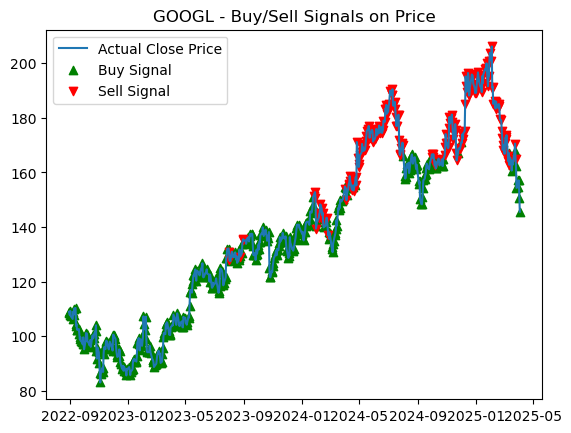

Trend prediction accuracy for META: 47.55%

Sample predictions:
2022-08-29 | Close: $158.42 | Signal: Buy
2022-08-30 | Close: $156.42 | Signal: Buy
2022-08-31 | Close: $162.17 | Signal: Buy
2022-09-01 | Close: $164.58 | Signal: Buy
2022-09-02 | Close: $159.57 | Signal: Buy
2022-09-06 | Close: $157.80 | Signal: Buy
2022-09-07 | Close: $159.64 | Signal: Buy
2022-09-08 | Close: $161.30 | Signal: Buy
2022-09-09 | Close: $168.36 | Signal: Buy
2022-09-12 | Close: $168.17 | Signal: Buy


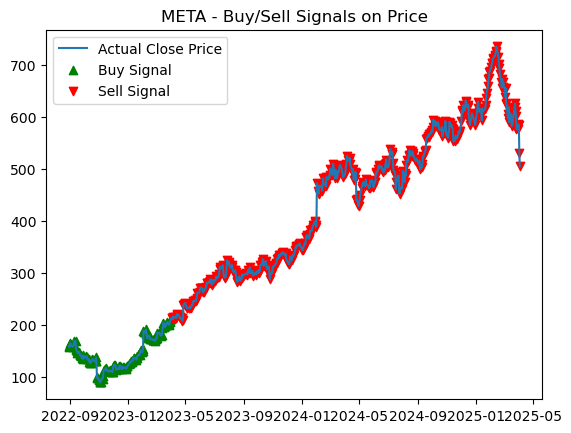

Trend prediction accuracy for NFLX: 48.93%

Sample predictions:
2022-08-29 | Close: $224.57 | Signal: Buy
2022-08-30 | Close: $220.65 | Signal: Buy
2022-08-31 | Close: $223.56 | Signal: Buy
2022-09-01 | Close: $230.04 | Signal: Buy
2022-09-02 | Close: $226.11 | Signal: Buy
2022-09-06 | Close: $218.39 | Signal: Buy
2022-09-07 | Close: $228.96 | Signal: Buy
2022-09-08 | Close: $227.44 | Signal: Buy
2022-09-09 | Close: $233.57 | Signal: Buy
2022-09-12 | Close: $236.53 | Signal: Buy


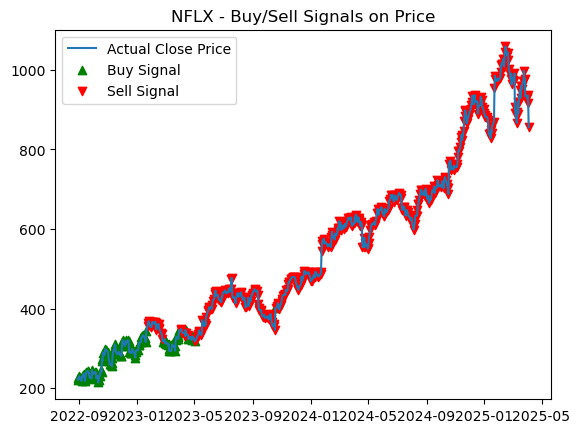

Trend prediction accuracy for TMUS: 45.09%

Sample predictions:
2022-08-29 | Close: $141.69 | Signal: Sell
2022-08-30 | Close: $142.31 | Signal: Sell
2022-08-31 | Close: $140.78 | Signal: Sell
2022-09-01 | Close: $140.74 | Signal: Sell
2022-09-02 | Close: $138.84 | Signal: Sell
2022-09-06 | Close: $138.78 | Signal: Sell
2022-09-07 | Close: $142.29 | Signal: Sell
2022-09-08 | Close: $142.16 | Signal: Sell
2022-09-09 | Close: $142.48 | Signal: Sell
2022-09-12 | Close: $141.94 | Signal: Sell


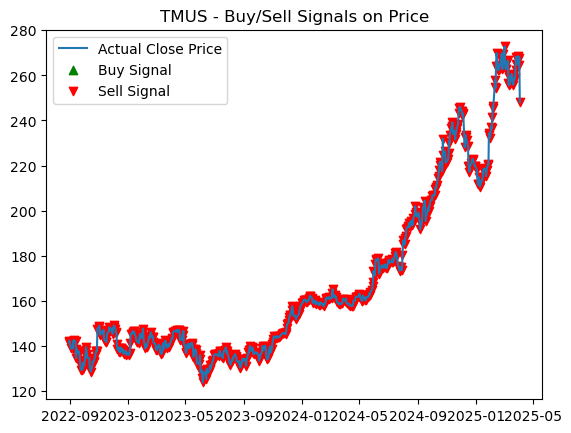

Trend prediction accuracy for DIS: 50.00%

Sample predictions:
2022-08-29 | Close: $112.14 | Signal: Buy
2022-08-30 | Close: $111.06 | Signal: Buy
2022-08-31 | Close: $110.71 | Signal: Buy
2022-09-01 | Close: $111.16 | Signal: Buy
2022-09-02 | Close: $109.84 | Signal: Buy
2022-09-06 | Close: $108.75 | Signal: Buy
2022-09-07 | Close: $111.31 | Signal: Buy
2022-09-08 | Close: $110.96 | Signal: Buy
2022-09-09 | Close: $113.77 | Signal: Buy
2022-09-12 | Close: $114.97 | Signal: Buy


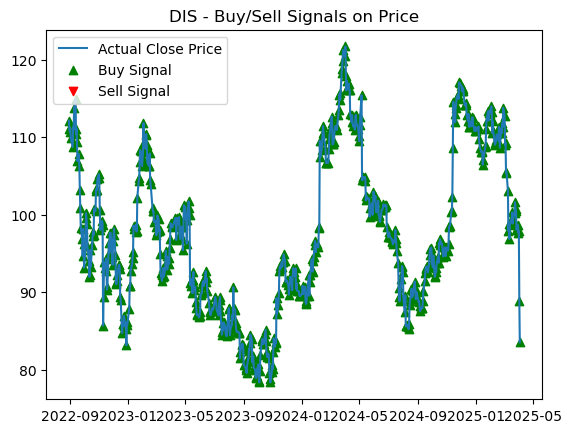

Trend prediction accuracy for T: 48.77%

Sample predictions:
2022-08-29 | Close: $15.22 | Signal: Buy
2022-08-30 | Close: $15.26 | Signal: Buy
2022-08-31 | Close: $15.02 | Signal: Buy
2022-09-01 | Close: $14.98 | Signal: Buy
2022-09-02 | Close: $14.72 | Signal: Buy
2022-09-06 | Close: $14.37 | Signal: Buy
2022-09-07 | Close: $14.44 | Signal: Buy
2022-09-08 | Close: $14.36 | Signal: Buy
2022-09-09 | Close: $14.58 | Signal: Buy
2022-09-12 | Close: $14.88 | Signal: Buy


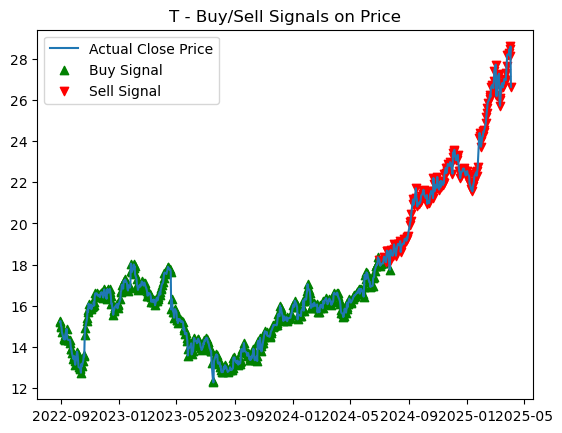

Trend prediction accuracy for VZ: 52.76%

Sample predictions:
2022-08-29 | Close: $36.57 | Signal: Buy
2022-08-30 | Close: $35.89 | Signal: Buy
2022-08-31 | Close: $35.29 | Signal: Buy
2022-09-01 | Close: $35.29 | Signal: Buy
2022-09-02 | Close: $34.86 | Signal: Buy
2022-09-06 | Close: $34.69 | Signal: Buy
2022-09-07 | Close: $34.67 | Signal: Buy
2022-09-08 | Close: $34.87 | Signal: Buy
2022-09-09 | Close: $35.65 | Signal: Buy
2022-09-12 | Close: $36.09 | Signal: Buy


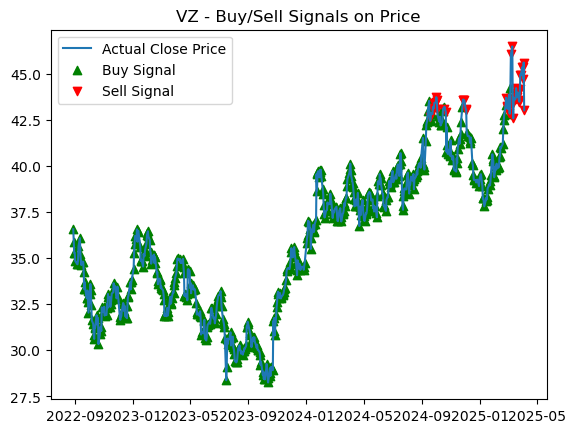

Trend prediction accuracy for CMCSA: 49.69%

Sample predictions:
2022-08-29 | Close: $33.34 | Signal: Buy
2022-08-30 | Close: $32.82 | Signal: Buy
2022-08-31 | Close: $33.25 | Signal: Buy
2022-09-01 | Close: $33.90 | Signal: Buy
2022-09-02 | Close: $32.85 | Signal: Buy
2022-09-06 | Close: $31.91 | Signal: Buy
2022-09-07 | Close: $32.14 | Signal: Buy
2022-09-08 | Close: $31.57 | Signal: Buy
2022-09-09 | Close: $32.55 | Signal: Buy
2022-09-12 | Close: $32.79 | Signal: Buy


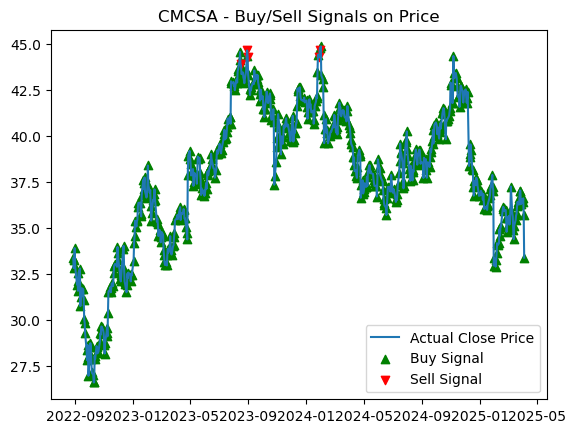

Trend prediction accuracy for SPOT: 45.62%

Sample predictions:
2022-08-30 | Close: $107.23 | Signal: Buy
2022-08-31 | Close: $108.15 | Signal: Buy
2022-09-01 | Close: $106.52 | Signal: Buy
2022-09-02 | Close: $104.42 | Signal: Buy
2022-09-06 | Close: $102.59 | Signal: Buy
2022-09-07 | Close: $105.86 | Signal: Buy
2022-09-08 | Close: $105.18 | Signal: Buy
2022-09-09 | Close: $110.28 | Signal: Buy
2022-09-12 | Close: $111.34 | Signal: Buy
2022-09-13 | Close: $101.96 | Signal: Buy


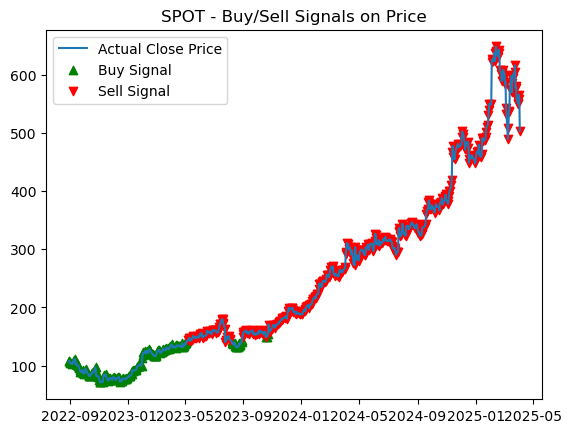

Trend prediction accuracy for CHTR: 49.54%

Sample predictions:
2022-08-29 | Close: $418.30 | Signal: Buy
2022-08-30 | Close: $409.51 | Signal: Buy
2022-08-31 | Close: $412.63 | Signal: Buy
2022-09-01 | Close: $420.33 | Signal: Buy
2022-09-02 | Close: $407.14 | Signal: Buy
2022-09-06 | Close: $397.00 | Signal: Buy
2022-09-07 | Close: $402.55 | Signal: Buy
2022-09-08 | Close: $395.91 | Signal: Buy
2022-09-09 | Close: $405.91 | Signal: Buy
2022-09-12 | Close: $406.45 | Signal: Buy


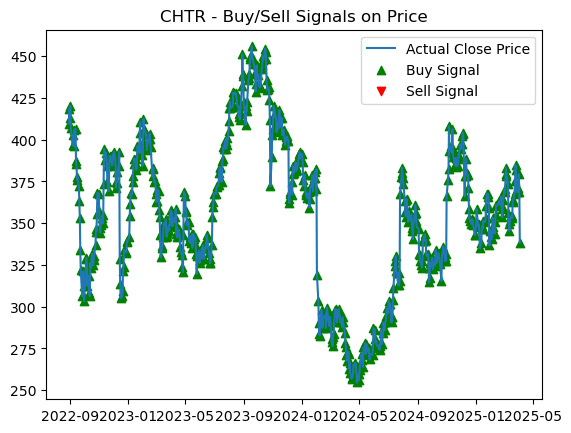

Average Accuracy: 49.34%


In [34]:
for target in targets:
    temp_df = df.copy()
    cols = [f'Close_{target}', f'High_{target}', f'Low_{target}']
    temp_df[cols] = temp_df[cols].astype(float)
    temp_df['Prev_Close'] = temp_df[f'Close_{target}'].shift(1)
    temp_df['Target_Up'] = (temp_df[f'Close_{target}'] > temp_df['Prev_Close']).astype(int)

    temp_df.dropna(inplace=True)
    
    scaler = MinMaxScaler()
    X = temp_df[['Prev_Close', 'UNRATE','Unrate_Pct_Change']].values
    scaled = scaler.fit_transform(X)
    y = temp_df['Target_Up'].values

    split = int(len(X) * 0.63)
    X_train, y_train = X[:split], y[:split]
    X_test, y_test = X[split:], y[split:]
    dates_test = temp_df['Date'].iloc[split:]
    real_close = temp_df[f'Close_{target}'].iloc[split:].values

    model = LogisticRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    signals = np.where(y_pred == 1, 'Buy', 'Sell')

    real_trend = np.where(np.diff(real_close) > 0, 1, 0)
    pred_trend = y_pred[:-1]
    trend_accuracy = accuracy_score(real_trend, pred_trend)
    accuracies.append(trend_accuracy)
    print(f"Trend prediction accuracy for {target}: {trend_accuracy:.2%}")
    print("\nSample predictions:")
    for i in range(10):
        print(f"{dates_test.iloc[i].date()} | Close: ${real_close[i]:.2f} | Signal: {signals[i]}")
    plt.plot(dates_test, real_close, label="Actual Close Price")

    # Overlay buy/sell signals
    buy_signals = dates_test[y_pred == 1]
    sell_signals = dates_test[y_pred == 0]

    plt.scatter(buy_signals, real_close[y_pred == 1], marker='^', color='g', label='Buy Signal')
    plt.scatter(sell_signals, real_close[y_pred == 0], marker='v', color='r', label='Sell Signal')

    plt.legend()
    plt.title(f"{target} - Buy/Sell Signals on Price")
    plt.show()
print(f"Average Accuracy: {sum(accuracies) / len(accuracies):.2%}")